<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/AP_Torch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is all about discussion on torch Workflow along with an comprehensive study on a Regression Model and a Classification Model.

In [ ]:
# # run once
# !pip install black[jupyter] --quiet
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [208]:
!pip install torchview
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.8 MB/s eta 0:00:00


In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [120]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

## Torch Workflow fundamentals using a MNIST dataset -- to setup the premise

```md
| Topic                                                    | Contents                                                                                                                          |
|----------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
| 1. Getting data ready                                    | Data can be almost anything but to get started we're going to create a simple straight line                                       |
| 2. Building a model                                      | Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.  |
| 3. Fitting the model to data (training)                  | We've got data and a model, now let's let the model (try to) find patterns in the (training) data.                                |
| 4. Making predictions and evaluating a model (inference) | Our model's found patterns in the data, let's compare its findings to the actual (testing) data.                                  |
| 5. Saving and loading a model                            | You may want to use your model elsewhere, or come back to it later, here we'll cover that.                                        |
|                                                          |                                                                                                                                   |

```

##### Key Pointers:
1. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
2. We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading.
3. nn.Module contains the larger building blocks (layers)
4. nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
5. forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
6. torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data.
7. in older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred

##### Data Loading

In [122]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)

Random seed set as 42


In [ ]:
# downloading the training data from Datasets library
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
batch_size = 128
epochs = 10
lr = 1e-3

In [ ]:
print(training_data.data.shape)
print(test_data.data.shape)
print(training_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])


In [ ]:
# wrapping the raw data into dataloader class
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


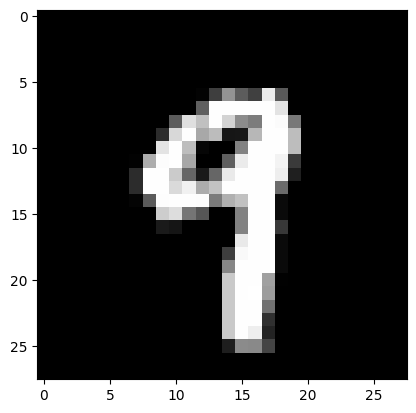

Label: 9


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # Torch.Size([28, 28])
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

##### Model Definition Piece

In [ ]:
class SimpleNN(nn.Module):
  """Simple NN model"""
  def __init__(self, input_size, num_classes):
    super(SimpleNN, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x: torch.Tensor):
    x = self.flatten(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
# declaring the model
model = SimpleNN(input_size=28*28, num_classes=10).to(device)
print(model.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [ ]:
# summarization of the model layers
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
            Linear-3                   [-1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


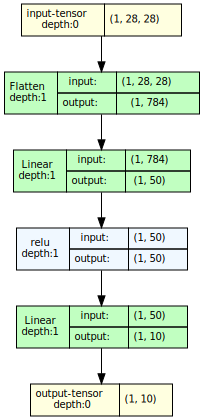

In [ ]:
# graphical representation of the model architecture
model_graph = draw_graph(model, input_size=(1, 28, 28), expand_nested=True)
model_graph.visual_graph

##### Train the model - loss and Optimizer

```md
| Function      | What does it do?                                                                                                            |
|---------------|-----------------------------------------------------------------------------------------------------------------------------|
| Loss function | Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better. |
| Optimizer     | Tells your model how to update its internal parameters to best lower the loss.                                              |
```

In [ ]:
# Init loss function - common options are nn.CrossEntropyLoss,nn.BCELoss,nn.BCEWithLogitsLoss
loss_fn = nn.CrossEntropyLoss()

# Init optimizers- common options are Adam, SGD ,RMSprop
optimizer = torch.optim.SGD(model.parameters(), lr)

# defining a custom metric - later we will use torch metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

##### Training steps - Design for the training module
```md
| Number | Step name                               | What does it do?                                                                                                                                                                      | Code example                     |
|--------|-----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------|
| 1      | Forward pass                            | The model goes through all of the training data once, performing its forward() function calculations.                                                                                 | model(x_train)                   |
| 2      | Calculate the loss                      | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.                                                                           | loss = loss_fn(y_pred, y_train)  |
| 3      | Zero gradients                          | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.                                                | optimizer.zero_grad()            |
| 4      | Perform backpropagation on the loss     | Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards". | loss.backward()                  |
| 5      | Update the optimizer (gradient descent) | Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.                                                                            | optimizer.step()                 |
```

In [ ]:
def train_loop(model, dataloader, loss_fn, optimizer):
  """Training loop"""
  train_size = len(dataloader.dataset)
  batch_cnt , batch_loss, batch_acc = 0, 0, 0
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    # model predictions in logits
    pred_logits = model(X)
    # loss calculation
    loss = loss_fn(pred_logits, y)
    # metric calculation
    pred_probs = F.softmax(pred_logits, dim=1)
    pred_classes = pred_probs.argmax(dim=1)
    acc = accuracy_fn(y, pred_classes)

    # backpropagation -> backprop -> optimize -> remove existing gradient
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    batch_loss += loss.item()
    batch_acc += acc
    batch_cnt += 1
    # print the loss and accuracy for predefiend set of batched under one epoch
    if batch % batch_size == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"loss: {loss:>7f} and Accuracy : {acc:>5f}[{current:>5d}/{train_size:>5d}]")

  batch_loss /= batch_cnt
  batch_acc /= batch_cnt
  print(f"Train Avg metrics: \n Accuracy: {(batch_acc):>0.1f}%, Avg loss: {batch_loss:>8f} \n")
  return batch_loss, batch_acc

##### validation steps - Design for the validation module
1. Declare placeholders for loss and accuracy
2. Init the model in eval mode
3. with no grad calculation context for each batch calculate loss and accuracy
4. Print the loss and accuracy by averaging over all batches

In [ ]:
def test_loop(model, dataloader, loss_fn):
  """Testing loop"""
  test_size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval() # putting the model in evaluation mode
  test_loss, test_acc = 0, 0
  with torch.no_grad(): # Context-manager that disables gradient calculation.
    for X,y in dataloader:
      X,y = X.to(device), y.to(device)
      pred_logits = model(X)
      # for each batches cal loss and accuracy and storing them
      test_loss += loss_fn(pred_logits, y).item()
      pred_probs = F.softmax(pred_logits, dim=1)
      pred_classes = pred_probs.argmax(dim=1)
      test_acc += accuracy_fn(y, pred_classes)

  test_loss /= num_batches
  test_acc /= num_batches
  print(f"Test Error: \n Accuracy: {(test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, test_acc

##### epoch level iterations and loss tracking

In [ ]:
train_loss_values = []
test_loss_values = []
epoch_count = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss , train_acc = train_loop(model = model , dataloader=train_loader, loss_fn=loss_fn , optimizer=optimizer)
    test_loss , test_acc = test_loop(model = model , dataloader=test_loader, loss_fn=loss_fn)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)
    epoch_count.append(t)

Epoch 1
-------------------------------
loss: 2.300261 and Accuracy : 9.375000[  128/60000]
loss: 2.275981 and Accuracy : 15.625000[16512/60000]
loss: 2.272138 and Accuracy : 18.750000[32896/60000]
loss: 2.262360 and Accuracy : 21.875000[49280/60000]
Train Avg metrics: 
 Accuracy: 18.2%, Avg loss: 2.268570 

Test Error: 
 Accuracy: 28.2%, Avg loss: 2.231076 

Epoch 2
-------------------------------
loss: 2.221874 and Accuracy : 32.031250[  128/60000]
loss: 2.220694 and Accuracy : 29.687500[16512/60000]
loss: 2.166821 and Accuracy : 42.968750[32896/60000]
loss: 2.176263 and Accuracy : 38.281250[49280/60000]
Train Avg metrics: 
 Accuracy: 34.8%, Avg loss: 2.191428 

Test Error: 
 Accuracy: 41.5%, Avg loss: 2.143644 

Epoch 3
-------------------------------
loss: 2.135492 and Accuracy : 42.968750[  128/60000]
loss: 2.147303 and Accuracy : 37.500000[16512/60000]
loss: 2.094316 and Accuracy : 46.875000[32896/60000]
loss: 2.053289 and Accuracy : 52.343750[49280/60000]
Train Avg metrics: 
 Ac

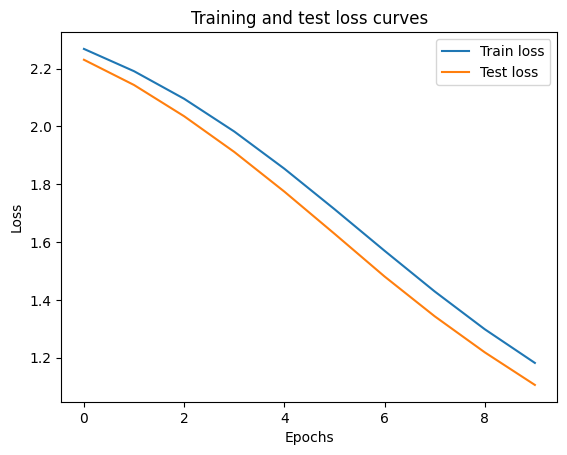

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

##### Saving and loading a PyTorch model

```md
| PyTorch method                  | What does it do?                                                                                                                                                                                               |
|---------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| torch.save                      | Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.                                             |
| torch.load                      | Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).  |
| torch.nn.Module.load_state_dict | Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.                                                                                                                   |
```

In [ ]:
# ideal way is to save only the trained model weights
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


In [ ]:
# loading of the weights of pre-trained model
new_model = SimpleNN(input_size=28*28, num_classes=10)
new_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
new_model.to(device)
print(f"Loaded model:\n{new_model}")

Loaded model:
SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
# one test prediction
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
new_model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Sneaker", Actual: "Sneaker"


## Deep Neural Regression Model

* Custom dataset creation for panel data
* Advanced training and evaluation mechanism reusable and stable

In [268]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# hyper params
batch_size = 32
epochs = 10
lr = 1e-3

Random seed set as 42
Using cuda device


##### Custom dataset and data loader

In [269]:
# reading the boston data set--
boston_df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")
print(boston_df.shape)

(506, 14)


In [270]:
# train test split
X= boston_df.drop(columns=["medv"])
y = boston_df["medv"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print(train_x.shape,test_x.shape)

(404, 13) (102, 13)


In [271]:
# Custom torch dataset for tensor enablement
class BostonDataset(Dataset):

  def __init__(self,X,y,scaled=False):

    if not scaled:
      X = StandardScaler().fit_transform(X.values)

    if not torch.is_tensor(X):
      self.X = torch.tensor(X, dtype=torch.float32).to(device)

    if not torch.is_tensor(y):
      self.y = torch.tensor(y.values, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [272]:
train_dataset = BostonDataset(train_x, train_y)
test_dataset = BostonDataset(test_x, test_y)

In [273]:
next(iter(train_dataset))

(tensor([ 1.2877, -0.5003,  1.0332, -0.2781,  0.4893, -1.4281,  1.0280, -0.8022,
          1.7069,  1.5784,  0.8453, -0.0743,  1.7535], device='cuda:0'),
 tensor(12., device='cuda:0'))

In [274]:
# dataloader class
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True )

In [276]:
for epoch in range(epochs):
  print(f"The epoch is {epoch}")
  for idx, (data,label) in enumerate(train_dataloader):
    print(f"The batch id is:: {idx}")
    print(f"The shape of a batch data in one epoch:: {data.shape}")
    print(f"The shape of the batch label in one epoch:: {len(label)}")
  break


The epoch is 0
The batch id is:: 0
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 1
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 2
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 3
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 4
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 5
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 6
The shape of a batch data in one epoch:: torch.Size([32, 13])
The shape of the batch label in one epoch:: 32
The batch id is:: 7
The shape of a batch data in one epoch:: torch.Size([32, 13])


##### Model definition

In [277]:
class BaseLinearModel(nn.Module):
    """Base class inheriting from nn.Module for multi-linear regression"""

    def __init__(self, input_dim, output_dim, neurons):
        super(BaseLinearModel, self).__init__()
        self.linear_layer1 = nn.Linear(in_features=input_dim, out_features=neurons)
        self.linear_layer2 = nn.Linear(in_features=neurons, out_features=2 * neurons)
        self.linear_layer3 = nn.Linear(in_features=2 * neurons, out_features=output_dim)

    def forward(self, x: torch.Tensor):
        x = F.relu(self.linear_layer1(x))
        x = F.relu(self.linear_layer2(x))
        op = self.linear_layer3(x)

        return op

In [278]:
lmodel = BaseLinearModel(input_dim=train_dataset.X.shape[1], output_dim=1, neurons=16).to(device)
print(lmodel)
print(lmodel.state_dict().keys())

BaseLinearModel(
  (linear_layer1): Linear(in_features=13, out_features=16, bias=True)
  (linear_layer2): Linear(in_features=16, out_features=32, bias=True)
  (linear_layer3): Linear(in_features=32, out_features=1, bias=True)
)
odict_keys(['linear_layer1.weight', 'linear_layer1.bias', 'linear_layer2.weight', 'linear_layer2.bias', 'linear_layer3.weight', 'linear_layer3.bias'])


In [279]:
for name, param in lmodel.named_parameters():
  print(name, '\t\t', param.shape)

linear_layer1.weight 		 torch.Size([16, 13])
linear_layer1.bias 		 torch.Size([16])
linear_layer2.weight 		 torch.Size([32, 16])
linear_layer2.bias 		 torch.Size([32])
linear_layer3.weight 		 torch.Size([1, 32])
linear_layer3.bias 		 torch.Size([1])


In [280]:
summary(lmodel, (train_dataset.X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             224
            Linear-2                   [-1, 32]             544
            Linear-3                    [-1, 1]              33
Total params: 801
Trainable params: 801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


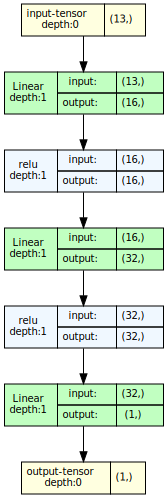

In [281]:
model_graph = draw_graph(lmodel, input_size = (train_dataset.X.shape[1],), expand_nested=True)
model_graph.visual_graph

##### Model Training and Evaluation Module

Training Loop --- Per Epoch
* set the model in training mode (model.train()).
* Forward pass - The model goes through batch of training data, performing its forward() function calculations (model(x_train)).
* Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
* Calculate any metric - Accuracy or any other metric
* Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
* Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
* Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [282]:
def train_module(model, device, train_dataloader , optimizer, criterion, metric, train_losses, train_metrics):
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data).squeeze()

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    metric_vl = metric(preds,label).detach()
    train_metric += metric_vl.item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


Validation Loop --- Per Epoch
* set the model in validatipon mode (model.eval()).
* Forward pass - The model goes through batch of training data, performing its forward() function calculations (model(x_val)).
* Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
* Calculate any metric - Accuracy or any other metric
* Send the avg loss and metric value for the batches

In [283]:
def test_module(model, device, test_dataloader, criterion, metric, test_losses, test_metrics):
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data).squeeze()
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      metric_vl = metric(preds, label).detach()
      test_metric += metric_vl.item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [284]:
# custom metric
class RMSE(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [285]:
# model declaration
rg_model = BaseLinearModel(input_dim=train_dataset.X.shape[1], output_dim=1, neurons=16).to(device)

In [286]:
# setting up the drivers
optimizer = torch.optim.SGD(rg_model.parameters(), lr=lr, momentum=0.9)
criterion = nn.MSELoss()
metric = RMSE()

In [287]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs+3):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(rg_model, device, train_dataloader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(rg_model, device, test_dataloader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 463.6839071420523 Avg Train Metric: 21.00995320540208: 100%|██████████| 13/13 [00:00<00:00, 204.57it/s]
Avg Test Loss: 76.20767211914062 Avg Test Metric: 8.66476571559906: 100%|██████████| 4/4 [00:00<00:00, 271.39it/s]


Epoch 1


Avg Train Loss: 69.72872455303485 Avg Train Metric: 7.981389742631179: 100%|██████████| 13/13 [00:00<00:00, 201.80it/s]
Avg Test Loss: 47.02785778045654 Avg Test Metric: 6.75347900390625: 100%|██████████| 4/4 [00:00<00:00, 237.46it/s]


Epoch 2


Avg Train Loss: 27.021309412442722 Avg Train Metric: 5.012402552824754: 100%|██████████| 13/13 [00:00<00:00, 211.40it/s]
Avg Test Loss: 23.430918216705322 Avg Test Metric: 4.703443169593811: 100%|██████████| 4/4 [00:00<00:00, 330.03it/s]


Epoch 3


Avg Train Loss: 20.836129188537598 Avg Train Metric: 4.428732285132775: 100%|██████████| 13/13 [00:00<00:00, 214.31it/s]
Avg Test Loss: 17.968337535858154 Avg Test Metric: 4.029849350452423: 100%|██████████| 4/4 [00:00<00:00, 343.67it/s]


Epoch 4


Avg Train Loss: 21.73661840879 Avg Train Metric: 4.530301570892334: 100%|██████████| 13/13 [00:00<00:00, 165.85it/s]
Avg Test Loss: 30.990097045898438 Avg Test Metric: 5.455651044845581: 100%|██████████| 4/4 [00:00<00:00, 352.48it/s]


Epoch 5


Avg Train Loss: 22.785695186028114 Avg Train Metric: 4.550528269547683: 100%|██████████| 13/13 [00:00<00:00, 210.13it/s]
Avg Test Loss: 15.630128383636475 Avg Test Metric: 3.86892306804657: 100%|██████████| 4/4 [00:00<00:00, 382.87it/s]


Epoch 6


Avg Train Loss: 14.95409345626831 Avg Train Metric: 3.7550935378441443: 100%|██████████| 13/13 [00:00<00:00, 213.40it/s]
Avg Test Loss: 16.81273341178894 Avg Test Metric: 3.9936476945877075: 100%|██████████| 4/4 [00:00<00:00, 264.83it/s]


Epoch 7


Avg Train Loss: 13.349650566394512 Avg Train Metric: 3.5160515950276303: 100%|██████████| 13/13 [00:00<00:00, 202.48it/s]
Avg Test Loss: 15.392425537109375 Avg Test Metric: 3.8278605937957764: 100%|██████████| 4/4 [00:00<00:00, 339.21it/s]


Epoch 8


Avg Train Loss: 11.237594861250658 Avg Train Metric: 3.2521106463212233: 100%|██████████| 13/13 [00:00<00:00, 209.66it/s]
Avg Test Loss: 13.948014259338379 Avg Test Metric: 3.611698031425476: 100%|██████████| 4/4 [00:00<00:00, 315.51it/s]


Epoch 9


Avg Train Loss: 10.068504370175875 Avg Train Metric: 3.113023959673368: 100%|██████████| 13/13 [00:00<00:00, 175.85it/s]
Avg Test Loss: 35.31211543083191 Avg Test Metric: 5.113208055496216: 100%|██████████| 4/4 [00:00<00:00, 298.44it/s]


Epoch 10


Avg Train Loss: 10.718766542581411 Avg Train Metric: 3.192104156200702: 100%|██████████| 13/13 [00:00<00:00, 219.50it/s]
Avg Test Loss: 20.745941162109375 Avg Test Metric: 4.437847852706909: 100%|██████████| 4/4 [00:00<00:00, 273.87it/s]


Epoch 11


Avg Train Loss: 10.823227919065035 Avg Train Metric: 3.2219192064725437: 100%|██████████| 13/13 [00:00<00:00, 210.53it/s]
Avg Test Loss: 19.59444224834442 Avg Test Metric: 4.256195485591888: 100%|██████████| 4/4 [00:00<00:00, 363.03it/s]


Epoch 12


Avg Train Loss: 10.108043670654297 Avg Train Metric: 3.1325920545137844: 100%|██████████| 13/13 [00:00<00:00, 212.29it/s]
Avg Test Loss: 15.559421181678772 Avg Test Metric: 3.734891176223755: 100%|██████████| 4/4 [00:00<00:00, 294.77it/s]


Text(0.5, 1.0, 'Metrics Curve for Validation')

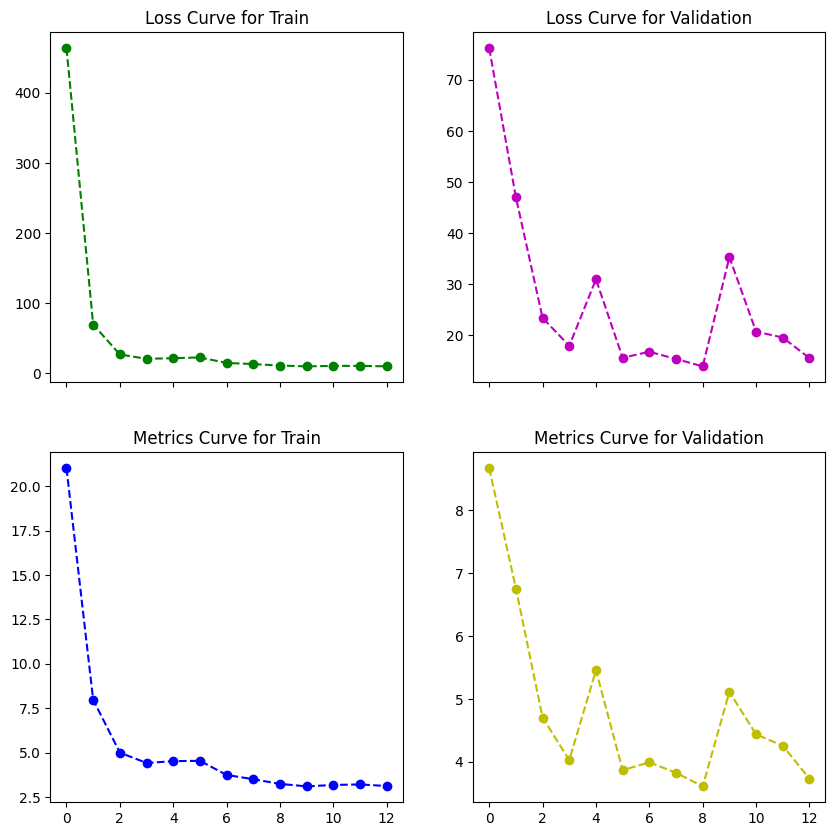

In [288]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 10))
ax[0,0].plot(train_losses, "g--o")
ax[0,0].set_title("Loss Curve for Train")
ax[0,1].plot(test_losses, "m--o")
ax[0,1].set_title("Loss Curve for Validation")
ax[1,0].plot(train_metrics, "b--o")
ax[1,0].set_title("Metrics Curve for Train")
ax[1,1].plot(test_metrics, "y--o")
ax[1,1].set_title("Metrics Curve for Validation")

## Torch Eval
Introduction of torch eval for out of the box metrics calculation

In [289]:
from torcheval.metrics import MulticlassAccuracy

metric = MulticlassAccuracy(device=device)
num_epochs, num_batches, batch_size = 2, 4, 10
num_classes = 3

# number of batches between metric computations
compute_frequency = 1

In [290]:
for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        input = torch.randint(high=num_classes, size=(batch_size,), device=device) # the predictions from the model
        target = torch.randint(high=num_classes, size=(batch_size,), device=device) # the groud truth labels

        # metric.update() updates the metric state with new data
        metric.update(input, target)
        metric_val = metric.compute()
        # metric_val = metric.compute().detach().item()

        # metric.compute() returns metric value from all seen data
        if (batch_idx + 1) % compute_frequency == 0:
                print(
                    "Epoch {}/{}, Batch {}/{} --- acc: {:.4f}".format(
                        epoch + 1,
                        num_epochs,
                        batch_idx + 1,
                        num_batches,
                        # metric.compute() returns metric value from all seen data
                        metric_val,
                    )
                )

    # metric.reset() reset metric states. It's typically called after the epoch completes.
    metric.reset()

Epoch 1/2, Batch 1/4 --- acc: 0.3000
Epoch 1/2, Batch 2/4 --- acc: 0.2500
Epoch 1/2, Batch 3/4 --- acc: 0.3000
Epoch 1/2, Batch 4/4 --- acc: 0.3000
Epoch 2/2, Batch 1/4 --- acc: 0.6000
Epoch 2/2, Batch 2/4 --- acc: 0.6500
Epoch 2/2, Batch 3/4 --- acc: 0.5000
Epoch 2/2, Batch 4/4 --- acc: 0.4750


The class metrics keeps track of metric states, which enables them to be able to calculate values through accumulations and synchronizations across multiple processes. The base class is torcheval.metrics.Metric.

The core APIs of class metrics are update(), compute() and reset().

* update(): Update the metric states with input data. This is often used when new data needs to be added for metric computation.
* compute(): Compute the metric values from the metric state, which are updated by previous update() calls. The compute frequency can be less than the update frequency.
* reset(): Reset the metric state variables to their default value. Usually this is called at the end of every epoch to clean up metric states.

## Deep Neural Classification Model
* tryout with Binary Classifier
* tryout with multiclass
* with and without final activation function
* Loss criterion for Binary: nn.BCEWithLogitsLoss will apply sigmoid activation internally for you but you should add it manually if you are using nn.BCELoss.
* Loss criterion for Multiclass: nn.CrossEntropyLoss and nn.NLLLoss. While the former uses a nn.LogSoftmax activation function internally, you would have to add it in the latter criterion.
* follow articles: https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586 , https://discuss.pytorch.org/t/difference-between-cross-entropy-loss-or-log-likelihood-loss/38816, https://jamesmccaffrey.wordpress.com/2020/06/11/pytorch-crossentropyloss-vs-nllloss-cross-entropy-loss-vs-negative-log-likelihood-loss/

In [291]:
from torcheval.metrics import BinaryAccuracy, MulticlassAccuracy

##### Binary Classification

In [292]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# hyper params
batch_size = 32
epochs = 10
lr = 1e-3

Random seed set as 42
Using cuda device


###### Basic Dataprep

In [293]:
# reading the boston data set--
notes_df = pd.read_csv("https://raw.githubusercontent.com/DARK-art108/Bank-Note-Authentication/master/Datasets/BankNote_Authentication.csv")
print(notes_df.shape)

(1372, 5)


In [294]:
# train test split
X= notes_df.drop(columns=["class"])
y = notes_df["class"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print(train_x.shape,test_x.shape)

(1097, 4) (275, 4)


In [295]:
# test_y.value_counts().plot.bar()

In [296]:
# Custom torch dataset for tensor enablement
class NotesDataset(Dataset):

  def __init__(self,X,y,scaled=False):

    if not scaled:
      X = StandardScaler().fit_transform(X.values)

    if not torch.is_tensor(X):
      self.X = torch.tensor(X, dtype=torch.float32).to(device)

    if not torch.is_tensor(y):
      self.y = torch.tensor(y.values, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [297]:
train_dataset = NotesDataset(train_x, train_y)
test_dataset = NotesDataset(test_x, test_y)

In [298]:
next(iter(train_dataset))

(tensor([-0.6392,  1.8056, -0.1884, -3.0510], device='cuda:0'),
 tensor(0., device='cuda:0'))

In [299]:
# dataloader class
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True )

In [300]:
for epoch in range(epochs):
  print(f"The epoch is {epoch}")
  for idx, (data,label) in enumerate(train_dataloader):
    print(f"The batch id is:: {idx}")
    print(f"The shape of a batch data in one epoch:: {data.shape}")
    print(f"The shape of the batch label in one epoch:: {len(label)}")
  break


The epoch is 0
The batch id is:: 0
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 1
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 2
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 3
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 4
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 5
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 6
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shape of the batch label in one epoch:: 32
The batch id is:: 7
The shape of a batch data in one epoch:: torch.Size([32, 4])
The shap

###### Model definition

In [301]:
class BinaryClassifier(nn.Module,):
  """Model class inheriting from nn.Module for binary classification"""
  def __init__(self, input_dims, output_dims, hidden_dims):
    super(BinaryClassifier, self).__init__()
    self.fc1 = nn.Linear(in_features = input_dims, out_features = hidden_dims)
    self.fc2 = nn.Linear(in_features = hidden_dims, out_features = hidden_dims * 2)
    self.fc3 = nn.Linear(in_features = hidden_dims*2 , out_features = output_dims)

  def forward(self, x):
    """To be used with loss BCEWithLogitsLoss as final activation function is applied internally """
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  # def forward(self, x):
  #   """To be used with loss BCELoss as final activation function is applied internally """
  #   x = F.relu(self.fc1(x))
  #   x = F.relu(self.fc2(x))
  #   x = self.fc3(x)
  #   return F.sigmoid(x)



In [302]:
# updated training module---

def train_module(model, device, train_dataloader , optimizer, criterion, metric, train_losses, train_metrics):
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data).squeeze()

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [303]:
# updated testing modules

def test_module(model, device, test_dataloader, criterion, metric, test_losses, test_metrics):
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data).squeeze()
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [304]:
# declaring model
bn_model = BinaryClassifier(input_dims = train_dataset.X.shape[1], output_dims = 1, hidden_dims = 32).to(device)

In [305]:
summary(bn_model, (train_dataset.X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             160
            Linear-2                   [-1, 64]           2,112
            Linear-3                    [-1, 1]              65
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [306]:
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
criterion = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.Adam(params=bn_model.parameters(), lr=lr)

metric = BinaryAccuracy(threshold= 0.5 , device = device)

In [307]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(bn_model, device, train_dataloader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(bn_model, device, test_dataloader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 0.616629467691694 Avg Train Metric: 0.559206475530352: 100%|██████████| 35/35 [00:00<00:00, 157.94it/s]
Avg Test Loss: 0.5544681747754415 Avg Test Metric: 0.5473959048589071: 100%|██████████| 9/9 [00:00<00:00, 222.40it/s]


Epoch 1


Avg Train Loss: 0.44067177942820956 Avg Train Metric: 0.6704613225800651: 100%|██████████| 35/35 [00:00<00:00, 142.11it/s]
Avg Test Loss: 0.3652596076329549 Avg Test Metric: 0.8102140360408359: 100%|██████████| 9/9 [00:00<00:00, 211.70it/s]


Epoch 2


Avg Train Loss: 0.24534214777605876 Avg Train Metric: 0.8713805760656085: 100%|██████████| 35/35 [00:00<00:00, 151.91it/s]
Avg Test Loss: 0.18603434827592638 Avg Test Metric: 0.9060509933365716: 100%|██████████| 9/9 [00:00<00:00, 256.93it/s]


Epoch 3


Avg Train Loss: 0.12291260478752 Avg Train Metric: 0.9603863767215184: 100%|██████████| 35/35 [00:00<00:00, 163.08it/s]
Avg Test Loss: 0.09660229707757632 Avg Test Metric: 0.9730408324135674: 100%|██████████| 9/9 [00:00<00:00, 277.09it/s]


Epoch 4


Avg Train Loss: 0.07081655977027757 Avg Train Metric: 0.9924627133778163: 100%|██████████| 35/35 [00:00<00:00, 166.78it/s]
Avg Test Loss: 0.06132839247584343 Avg Test Metric: 0.991921967930264: 100%|██████████| 9/9 [00:00<00:00, 265.02it/s]


Epoch 5


Avg Train Loss: 0.04648003881531102 Avg Train Metric: 0.9950540917260307: 100%|██████████| 35/35 [00:00<00:00, 175.71it/s]
Avg Test Loss: 0.04106402086714903 Avg Test Metric: 1.0: 100%|██████████| 9/9 [00:00<00:00, 265.36it/s]


Epoch 6


Avg Train Loss: 0.03383047080465725 Avg Train Metric: 0.9989121300833566: 100%|██████████| 35/35 [00:00<00:00, 157.86it/s]
Avg Test Loss: 0.030833346562253103 Avg Test Metric: 1.0: 100%|██████████| 9/9 [00:00<00:00, 277.10it/s]


Epoch 7


Avg Train Loss: 0.024453676106142148 Avg Train Metric: 1.0: 100%|██████████| 35/35 [00:00<00:00, 189.00it/s]
Avg Test Loss: 0.02192623395886686 Avg Test Metric: 1.0: 100%|██████████| 9/9 [00:00<00:00, 290.10it/s]


Epoch 8


Avg Train Loss: 0.01818336694102202 Avg Train Metric: 1.0: 100%|██████████| 35/35 [00:00<00:00, 155.05it/s]
Avg Test Loss: 0.017830988806154992 Avg Test Metric: 1.0: 100%|██████████| 9/9 [00:00<00:00, 195.64it/s]


Epoch 9


Avg Train Loss: 0.014804840580161129 Avg Train Metric: 1.0: 100%|██████████| 35/35 [00:00<00:00, 159.71it/s]
Avg Test Loss: 0.013561041870464882 Avg Test Metric: 1.0: 100%|██████████| 9/9 [00:00<00:00, 215.46it/s]


Text(0.5, 1.0, 'Metrics Curve for Validation')

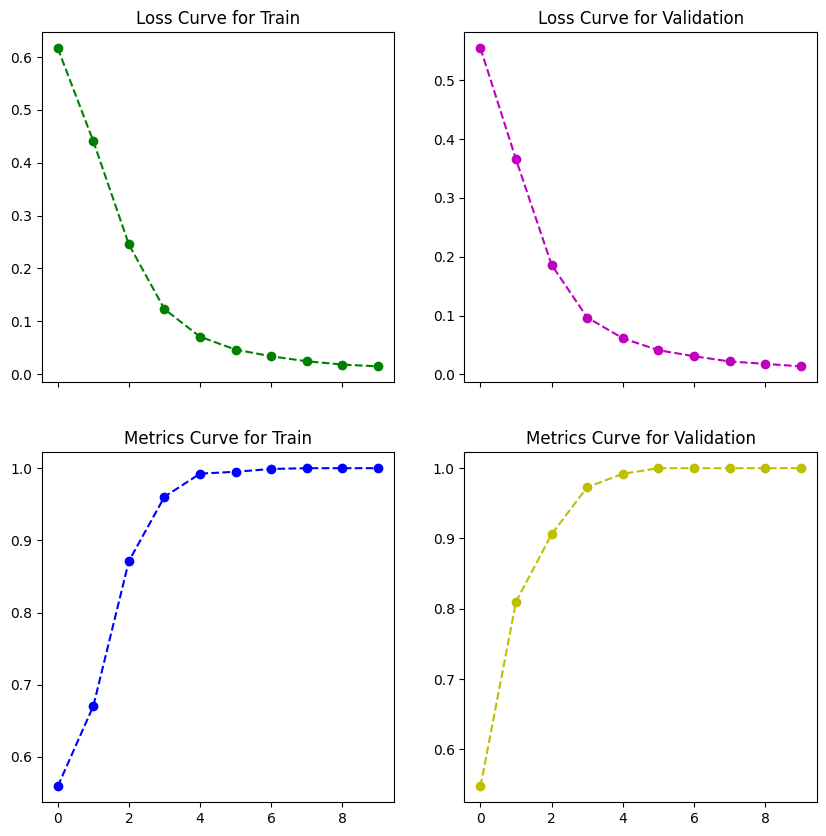

In [308]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 10))
ax[0,0].plot(train_losses, "g--o")
ax[0,0].set_title("Loss Curve for Train")
ax[0,1].plot(test_losses, "m--o")
ax[0,1].set_title("Loss Curve for Validation")
ax[1,0].plot(train_metrics, "b--o")
ax[1,0].set_title("Metrics Curve for Train")
ax[1,1].plot(test_metrics, "y--o")
ax[1,1].set_title("Metrics Curve for Validation")